In [17]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
import numpy as np
import random
import sys

sys.path.append('../tools')

import os

import torch

import pandas as pd
from sklearn.model_selection import train_test_split
import pytorch_lightning as pl
import pytorch_lightning.loggers as pl_loggers
import pytorch_lightning.callbacks as pl_callbacks
import data_utility, annotation_utility
from models.rns_dataloader import *
from active_learning_utility import get_strategy
from active_learning_data import Data
from active_learning_net import Net
from copy import deepcopy
from models.SwaV import SwaV
from models.LSTMDownStream import SupervisedDownstream
import warnings
import pickle
warnings.filterwarnings("ignore")


In [19]:
from sklearn.model_selection import KFold
import torch.nn as nn
import sklearn
def get_accuracy_scores(pred_raw, target, out, episode_out, episode_target):

    kf = KFold(n_splits=10, shuffle=True, random_state=42)
    accuracies = []
    f1_scores = []
    auc_scores = []
    episode_acc = []
    episode_f1s = []
    for train_ind, test_ind in kf.split(out):
        pred_split, target_split, pred_raw_split = out[test_ind],target[test_ind],m(pred_raw.float())[:,1][test_ind]
        acc = sklearn.metrics.accuracy_score(pred_split, target_split)
        f1_score = sklearn.metrics.f1_score(pred_split, target_split, pos_label=1, average='macro')
        fpr, tpr, thresholds = sklearn.metrics.roc_curve(target_split, pred_raw_split, pos_label=1)
        auc = sklearn.metrics.auc(fpr, tpr)
        accuracies.append(acc)
        f1_scores.append(f1_score)
        auc_scores.append(auc)
    kf = KFold(n_splits=10, shuffle=True, random_state=42)
    for train_ind, test_ind in kf.split(episode_out):
        episode_pred_split, episode_target_split = episode_out[test_ind], episode_target[test_ind]
        episode_acc.append(sklearn.metrics.accuracy_score(episode_pred_split,episode_target_split))
        episode_f1s.append(sklearn.metrics.f1_score(episode_pred_split,episode_target_split, pos_label=1, average='macro'))
    return accuracies, f1_scores, auc_scores, episode_acc, episode_f1s

In [20]:
random_seed = 42
random.seed(random_seed)
torch.manual_seed(random_seed)
np.random.seed(random_seed)

if torch.cuda.is_available():
    torch.cuda.manual_seed(random_seed)
    # True ensures the algorithm selected by CUFA is deterministic
    torch.backends.cudnn.deterministic = True
    # torch.set_deterministic(True)
    # False ensures CUDA select the same algorithm each time the application is run
    torch.backends.cudnn.benchmark = False

import pytorch_lightning

pytorch_lightning.utilities.seed.seed_everything(seed=random_seed, workers=True)

Global seed set to 42


42

In [21]:
data_dir = "../../../user_data/"
log_folder_root = '../../../user_data/logs/'
ckpt_folder_root = '../../../user_data/checkpoints/'

In [22]:
strategy_name_list = ['LeastConfidence']
for strategy_name in strategy_name_list:
    nStart = 1
    nEnd = 20
    nQuery = 2
    args_task = {'n_epoch': 60,
                 'transform_train': True,
                 'strategy_name': strategy_name,
                 'transform': False,
                 'loader_tr_args': {'batch_size': 4, 'num_workers': 4, 'collate_fn': collate_fn,
                                    'drop_last': True, 'persistent_workers': True},
                 'loader_te_args': {'batch_size': 8, 'num_workers': 4, 'collate_fn': collate_fn,
                                    'drop_last': True, 'persistent_workers': True}
                 }
    data_list = ['HUP047.npy', 'HUP084.npy', 'HUP096.npy', 'HUP109.npy', 'HUP121.npy', 'HUP129.npy', 'HUP131.npy',
                 'HUP137.npy', 'HUP147.npy', 'HUP156.npy', 'HUP159.npy', 'HUP182.npy', 'HUP197.npy', 'HUP199.npy',
                 'RNS026.npy', 'RNS029.npy']
    # data_list = os.listdir(data_dir+'rns_test_cache')[1:]
    
    # data_list = ['HUP182.npy',   'HUP129.npy',   'HUP109.npy', 'HUP156.npy', 'HUP096.npy', 'RNS026.npy',  'HUP159.npy']
    # data_list = ['RNS026.npy', 'HUP159.npy', 'HUP129.npy', 'HUP096.npy', 'HUP182.npy']
    train_data, train_label, test_data, test_label, train_index, test_index = get_data_by_episode(data_list, split=0.8)
    # data, label,_,_ = get_data(data_list, split=1)
    # train_data, test_data, train_label, test_label = sklearn.model_selection.train_test_split(data, label, test_size=0.8, random_state=42)
    
    print(train_data.shape)
    print(train_label.shape)
    print(test_data.shape)
    print(test_label.shape)
    X_train = np.concatenate(train_data)
    y_train = np.concatenate(train_label)
    X_test = np.concatenate(test_data)
    y_test = np.concatenate(test_label)
    index_train = np.concatenate(train_index)
    index_test = np.concatenate(test_index)
    seq_len_train = np.array([y.shape[0] for y in train_label])
    seq_len_test = np.array([y.shape[0] for y in test_label])
    
    n_pool = len(train_data)
    n_test = len(test_data)
    
    NUM_INIT_LB = int(nStart * n_pool / 100)
    NUM_QUERY = int(nQuery * n_pool / 100) if nStart != 100 else 0
    NUM_ROUND = int((int(nEnd * n_pool / 100) - NUM_INIT_LB) / NUM_QUERY) if nStart != 100 else 0
    if NUM_QUERY != 0:
        if (int(nEnd * n_pool / 100) - NUM_INIT_LB) % NUM_QUERY != 0:
            NUM_ROUND += 1
    
    print(NUM_INIT_LB)
    print(NUM_QUERY)
    print(NUM_ROUND)
    
    NUM_ROUND = 10
    
    dataset = Data(X_train, y_train, X_test, y_test, seq_len_train, seq_len_test, RNS_Active_by_episode_LSTM, args_task)
    
    swav = SwaV().load_from_checkpoint(
        ckpt_folder_root + 'rns_swav_50_12/rns_swav-epoch=82-swav_loss=2.58204.ckpt')
    model = SupervisedDownstream(swav.backbone)
    # initialize model and save the model state
    modelstate = deepcopy(model.state_dict())
    device = "cuda" if torch.cuda.is_available() else "cpu"
    
    net = Net(model, args_task, device, ckpt_folder_root='rns_active', log_folder_root='rns_active')
    
    strategy = get_strategy(strategy_name, dataset, net, None, args_task, rns_data=True)
    
    trainer = pl.Trainer(accelerator='gpu',
                         devices=1,
                         precision=16,)
    
    strategy.net.trainer = trainer
    
    result_final = {}
    for rd in range(0, NUM_ROUND+1):
    # for rd in [10]:
        print('round ' + str(rd))
        log_file_name = log_folder_root + 'rns_active/active_logs_' + strategy_name + '/logger_round_' + str(
            rd) + '/version_0/metrics.csv'
        logs = pd.read_csv(log_file_name)
        # max_ind = logs['val_acc'].argmax()
        # max_row = logs.iloc[max_ind]
        sinds = np.argsort(list(logs['val_acc']))[::-1]
        ckpt_directory = ckpt_folder_root + 'rns_active/active_checkpoints_' + strategy_name
        ckpt_files = os.listdir(ckpt_directory)
        
        n = np.min((len(ckpt_files),1))
        
        selected_ind = sinds[~np.isnan(logs['val_acc'][sinds])][0]
    
        with open(log_folder_root + 'rns_active_selected/' + strategy_name + '/' + 'selected_indices.pkl', 'rb') as f:
                # Load the content of the file into a Python object
            selected_inds = pickle.load(f)
        
        q_idxs = np.array(selected_inds[rd])
        
        strategy.update(q_idxs)
        
        _, unlabeled_data = strategy.dataset.get_train_data_unaugmented()
        # all_test_data = strategy.dataset.get_test_data()
        
        s_idx = selected_ind
        max_row = logs.iloc[s_idx]
        load_file_name = strategy_name + '_round_' + str(rd) + '-step=' + str(int(max_row['step']+1))
        print(load_file_name)

        ind = next((i for i, s in enumerate(ckpt_files) if load_file_name in s), None)
        print(ind, ckpt_files[ind])
        strategy.net.net = strategy.net.net.load_from_checkpoint(ckpt_directory + '/' + ckpt_files[ind], backbone=swav.backbone)
    
        if rd == NUM_ROUND:
            predictions = strategy.net.run_prediction(unlabeled_data)
        
    #     result_list = []
    #     for s_idx in selected_ind:
    #         try:
    #             max_row = logs.iloc[s_idx]
    #             load_file_name = strategy_name + '_round_' + str(rd) + '-step=' + str(int(max_row['step']+1))
    #             print(load_file_name)
    #             
    #             ind = next((i for i, s in enumerate(ckpt_files) if load_file_name in s), None)
    #             print(ind, ckpt_files[ind])
    #             strategy.net.net = strategy.net.net.load_from_checkpoint(ckpt_directory + '/' + ckpt_files[ind], backbone=swav.backbone)
    #             
    #            
    #             output_list = []
    #             seq_len_list = []
    #             target_list = []
    #             emb_list = []
    #             m = nn.Softmax(dim=1)
    #             for pred, y, emb, emb_t, seq_len in predictions:
    #                 output_list.append(pred)
    #                 seq_len_list.append(seq_len)
    #                 target_list.append(y)
    #                 emb_list.append(emb)
    #             
    #             target = torch.concat(target_list)
    #             emb = torch.vstack(emb_list)
    #             pred_raw = torch.vstack(output_list).float()
    #             seq_len_out = torch.tensor([item for sublist in seq_len_list for item in sublist])
    #             probs = m(pred_raw)
    #             out = torch.argmax(pred_raw, dim=1)
    #             unlabeled_idxs, _ = strategy.dataset.get_unlabeled_data()
    #             
    #             pred_label_split = strategy.dataset.combine_window_to_episode(out, seq_len_train, ~strategy.dataset.labeled_idxs)
    #             test_label_split = strategy.dataset.combine_window_to_episode(target, seq_len_train, ~strategy.dataset.labeled_idxs)
    #             episode_out = torch.tensor([np.sign(tl.sum()) for tl in pred_label_split])
    #             episode_target = torch.tensor([np.sign(tl.sum()) for tl in test_label_split])
    #             
    #             result_list.append(get_accuracy_scores(pred_raw[unlabeled_idxs], target[unlabeled_idxs], out[unlabeled_idxs], episode_out, episode_target))
    #         except:
    #             continue
    #     
    #     result_final[rd] = result_list
    # 
    # # np.save('save_acc/'+ strategy_name + '.npy', result_final)
    del model
    # del strategy
    del swav
    del net

16it [00:05,  2.77it/s]


(992,)
(992,)
(270,)
(270,)
9
19
10


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


round 0
LeastConfidence_round_0-step=20
0 LeastConfidence_round_0-step=20-train_loss=0.01761.ckpt
round 1
LeastConfidence_round_1-step=240
11 LeastConfidence_round_1-step=240-train_loss=0.01148.ckpt
round 2
LeastConfidence_round_2-step=160
38 LeastConfidence_round_2-step=160-train_loss=0.01361.ckpt
round 3
LeastConfidence_round_3-step=180
57 LeastConfidence_round_3-step=180-train_loss=0.01796.ckpt
round 4
LeastConfidence_round_4-step=200
78 LeastConfidence_round_4-step=200-train_loss=0.01437.ckpt
round 5
LeastConfidence_round_5-step=360
106 LeastConfidence_round_5-step=360-train_loss=0.02000.ckpt
round 6
LeastConfidence_round_6-step=240
128 LeastConfidence_round_6-step=240-train_loss=0.02400.ckpt
round 7
LeastConfidence_round_7-step=240
150 LeastConfidence_round_7-step=240-train_loss=0.01333.ckpt
round 8
LeastConfidence_round_8-step=180
168 LeastConfidence_round_8-step=180-train_loss=0.02847.ckpt
round 9
LeastConfidence_round_9-step=80
196 LeastConfidence_round_9-step=80-train_loss=0.0

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


LeastConfidence_round_10-step=200
21 LeastConfidence_round_10-step=200-train_loss=0.02465.ckpt


Predicting: 0it [00:00, ?it/s]

In [7]:
strategy.dataset.get_test_data()

In [8]:
selected_inds.keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

In [9]:
index_train['patient_index'].unique()

AttributeError: 'numpy.ndarray' object has no attribute 'unique'

In [34]:
output_list = []
seq_len_list = []
target_list = []
emb_list = []
m = nn.Softmax(dim=1)
for pred, y, emb, emb_t, seq_len in predictions:
    output_list.append(pred)
    seq_len_list.append(seq_len)
    target_list.append(y)
    emb_list.append(emb)

target = torch.concat(target_list)
emb = torch.vstack(emb_list)
pred_raw = torch.vstack(output_list).float()
seq_len_out = torch.tensor([item for sublist in seq_len_list for item in sublist])
probs = m(pred_raw)
out = torch.argmax(pred_raw, dim=1)
# unlabeled_idxs, _ = strategy.dataset.get_unlabeled_data()
# 
# pred_label_split = strategy.dataset.combine_window_to_episode(out, seq_len_train, ~strategy.dataset.labeled_idxs)
# test_label_split = strategy.dataset.combine_window_to_episode(target, seq_len_train, ~strategy.dataset.labeled_idxs)
# episode_out = torch.tensor([np.sign(tl.sum()) for tl in pred_label_split])
# episode_target = torch.tensor([np.sign(tl.sum()) for tl in test_label_split])
# 
# get_accuracy_scores(pred_raw[unlabeled_idxs], target[unlabeled_idxs], out[unlabeled_idxs], episode_out, episode_target)

tensor([0, 0, 0,  ..., 0, 0, 0])

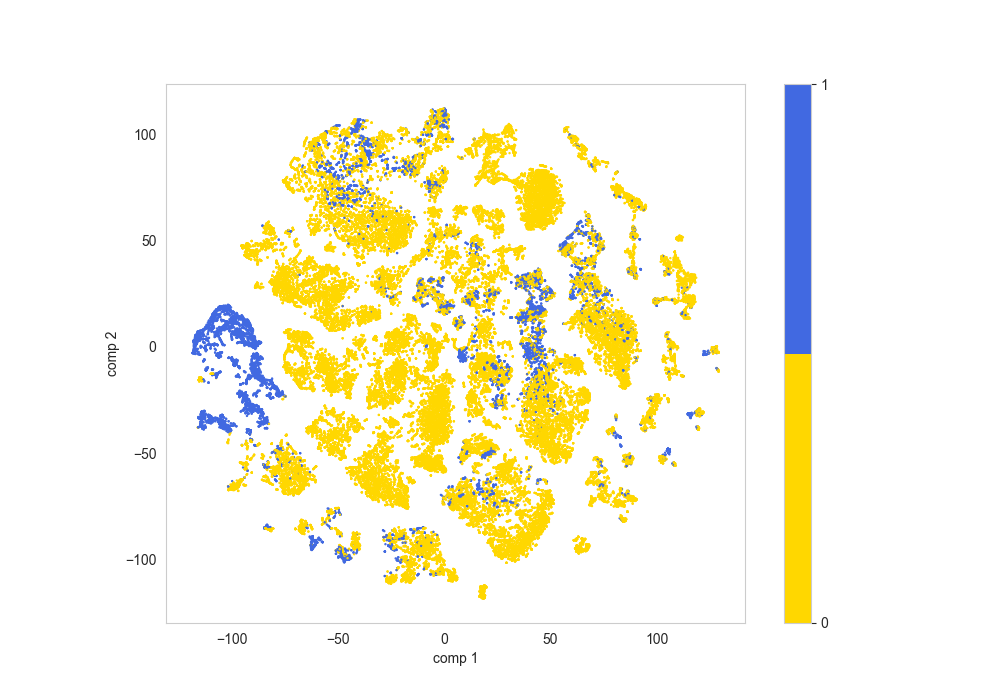

In [49]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.colors as mcolors
from matplotlib.colors import ListedColormap
from matplotlib.gridspec import GridSpec
import os
embedding_space_data = pd.read_csv('embedding_space_metrics.csv')
plt.figure(figsize=(10, 7))
cmap = ListedColormap(['gold', 'royalblue'])

scatter = plt.scatter(embedding_space_data.comp_1,embedding_space_data.comp_2,c=embedding_space_data.label,cmap=cmap, s=0.5)

plt.colorbar(scatter, ticks=[0, 1])
# plt.title('Swav Embedding t-SNE')
plt.xlabel('comp 1')
plt.ylabel("comp 2")
plt.gca().set_aspect('equal', adjustable='box')
plt.grid(False)
plt.show()

In [71]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
plt.figure(figsize=(10, 7))
cmap = ListedColormap(['gold', 'royalblue'])
interictal_inds = (target == 0).numpy()
ictal_inds = (target == 1).numpy()
# scatter = plt.scatter(embedding_space_data.comp_1[ictal_inds], embedding_space_data.comp_2[ictal_inds], c='royalblue',s=0.5)
# scatter = plt.scatter(embedding_space_data.comp_1[interictal_inds], embedding_space_data.comp_2[interictal_inds], c='gold',s=0.5)
scatter = plt.scatter(embedding_space_data.comp_1,embedding_space_data.comp_2,c=target,cmap=cmap, s=0.5)
scatter = plt.scatter(embedding_space_data.comp_1[42740:42803],embedding_space_data.comp_2[42740:42803],c='#54b345', s=20, edgecolor='black', zorder=3)
# Create custom legend
legend_elements = [Patch(facecolor='gold', edgecolor='gold', label='Interictal'),
                   Patch(facecolor='royalblue', edgecolor='royalblue', label='Ictal')]


# Labels for the legend elements
labels = ['interictal', 'ictal']
# Add legend to plot
plt.legend(handles=legend_elements, fontsize=11)

# plt.legend(legend_elements, labels, handler_map={tuple: HandlerTuple(ndivide=None)}, loc='upper right')
# Additional plot formatting
# plt.title('Swav Embedding t-SNE')
plt.xlabel('tSNE 1', fontsize=13)
plt.ylabel("tSNE 2", fontsize=13)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.grid(False)
plt.gca().set_aspect('equal', adjustable='box')
plt.savefig("embedding_with_label_label_with_points.svg", format="svg")
# Show plot
plt.show()

In [74]:
print(np.cumsum(seq_len_out)[517]+29,np.cumsum(seq_len_out)[518]+75)

tensor(42922) tensor(43057)


In [45]:
index_train[np.cumsum(seq_len_out)[518]:np.cumsum(seq_len_out)[519]]

array([(b'HUP131', 1857,  0, 54018259), (b'HUP131', 1857,  1, 54018259),
       (b'HUP131', 1857,  2, 54018259), (b'HUP131', 1857,  3, 54018259),
       (b'HUP131', 1857,  4, 54018259), (b'HUP131', 1857,  5, 54018259),
       (b'HUP131', 1857,  6, 54018259), (b'HUP131', 1857,  7, 54018259),
       (b'HUP131', 1857,  8, 54018259), (b'HUP131', 1857,  9, 54018259),
       (b'HUP131', 1857, 10, 54018259), (b'HUP131', 1857, 11, 54018259),
       (b'HUP131', 1857, 12, 54018259), (b'HUP131', 1857, 13, 54018259),
       (b'HUP131', 1857, 14, 54018259), (b'HUP131', 1857, 15, 54018259),
       (b'HUP131', 1857, 16, 54018259), (b'HUP131', 1857, 17, 54018259),
       (b'HUP131', 1857, 18, 54018259), (b'HUP131', 1857, 19, 54018259),
       (b'HUP131', 1857, 20, 54018259), (b'HUP131', 1857, 21, 54018259),
       (b'HUP131', 1857, 22, 54018259), (b'HUP131', 1857, 23, 54018259),
       (b'HUP131', 1857, 24, 54018259), (b'HUP131', 1857, 25, 54018259),
       (b'HUP131', 1857, 26, 54018259), (b'HUP131',

In [73]:
target[np.cumsum(seq_len_out)[517]:np.cumsum(seq_len_out)[518]].numpy()

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1], dtype=int64)

In [48]:
import matplotlib
# matplotlib.use('cairo')
from matplotlib.patches import Patch
from matplotlib.legend_handler import HandlerTuple
for p in np.unique(index_train['patient_index']):
    ind_p = index_train['patient_index'] == p
    ind_np = index_train['patient_index'] != p
    misclass = (out!=target).numpy()
    plt.figure(figsize=(10, 7))
    cmap = ListedColormap(['gold', 'royalblue'])
    interictal_inds = embedding_space_data.label == 0
    ictal_inds = embedding_space_data.label == 1
    scatter = plt.scatter(embedding_space_data.comp_1[ind_np],embedding_space_data.comp_2[ind_np],c='lightgrey',cmap=cmap, s=0.5)
    scatter = plt.scatter(embedding_space_data.comp_1[ind_p],embedding_space_data.comp_2[ind_p],c=target[ind_p],cmap=cmap, s=0.5)
    # scatter = plt.scatter(embedding_space_data.comp_1[np.logical_and(ind_p, interictal_inds)],embedding_space_data.comp_2[np.logical_and(ind_p, interictal_inds)],c='gold', s=0.5)
    # scatter = plt.scatter(embedding_space_data.comp_1[np.logical_and(ind_p, ictal_inds)],embedding_space_data.comp_2[np.logical_and(ind_p, ictal_inds)],c='royalblue', s=0.5)
    # scatter = plt.scatter(embedding_space_data.comp_1[ind_p],embedding_space_data.comp_2[ind_p],c=embedding_space_data.label[ind_p],cmap=cmap, s=0.5)
    plt.scatter(embedding_space_data.comp_1[np.logical_and(ind_p, misclass)],embedding_space_data.comp_2[np.logical_and(ind_p, misclass)],c='orangered', s=3, edgecolor='orangered',cmap=cmap)
    # Create custom legend
    legend_elements = [Patch(facecolor='gold', edgecolor='gold', label='Interictal'),
                       Patch(facecolor='royalblue', edgecolor='royalblue', label='Ictal'),
                       Patch(facecolor='orangered', edgecolor='orangered', label='False Example')]
    
    
    
    # Labels for the legend elements
    # labels = ['interictal', 'ictal']
    # Add legend to plot
    plt.legend(handles=legend_elements, loc = 'upper right',fontsize=11)
    
    # plt.legend(legend_elements, labels, handler_map={tuple: HandlerTuple(ndivide=None)}, loc='upper right')
    # Additional plot formatting
    plt.title(p)
    plt.xlabel('tSNE 1', fontsize=13)
    plt.ylabel("tSNE 2", fontsize=13)
    plt.xticks(fontsize=11)
    plt.yticks(fontsize=11)
    plt.grid(True)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.savefig("embedding_with_label_P = " + str(p) + ".svg", format="svg")
    # Show plot
    plt.show()

In [75]:
import matplotlib
matplotlib.use('cairo')
from matplotlib.patches import Patch
from matplotlib.legend_handler import HandlerTuple
p = b'HUP131'

ind_p = index_train['patient_index'] == p
ind_np = index_train['patient_index'] != p
misclass = (out!=target).numpy()
plt.figure(figsize=(10, 7))
cmap = ListedColormap(['gold', 'royalblue'])

interictal_inds = embedding_space_data.label == 0
ictal_inds = embedding_space_data.label == 1
scatter = plt.scatter(embedding_space_data.comp_1[ind_np],embedding_space_data.comp_2[ind_np],c='lightgrey',cmap=cmap, s=0.5)
scatter = plt.scatter(embedding_space_data.comp_1[ind_p],embedding_space_data.comp_2[ind_p],c=target[ind_p],cmap=cmap, s=0.5)
# scatter = plt.scatter(embedding_space_data.comp_1[np.logical_and(ind_p, interictal_inds)],embedding_space_data.comp_2[np.logical_and(ind_p, interictal_inds)],c='gold', s=0.5)
# scatter = plt.scatter(embedding_space_data.comp_1[np.logical_and(ind_p, ictal_inds)],embedding_space_data.comp_2[np.logical_and(ind_p, ictal_inds)],c='royalblue', s=0.5)
# scatter = plt.scatter(embedding_space_data.comp_1[ind_p],embedding_space_data.comp_2[ind_p],c=embedding_space_data.label[ind_p],cmap=cmap, s=0.5)
plt.scatter(embedding_space_data.comp_1[np.logical_and(ind_p, misclass)],embedding_space_data.comp_2[np.logical_and(ind_p, misclass)],c='orangered', s=3, edgecolor='orangered',cmap=cmap)
# scatter = plt.scatter(embedding_space_data.comp_1[41486:41532],embedding_space_data.comp_2[41486:41532],c='#c4a5de', s=20, edgecolor='black', zorder=3)
scatter = plt.scatter(embedding_space_data.comp_1[42922:43057],embedding_space_data.comp_2[42922:43057],c='#c4a5de', s=20, edgecolor='black', zorder=3)
# Create custom legend
legend_elements = [Patch(facecolor='gold', edgecolor='gold', label='Interictal'),
                   Patch(facecolor='royalblue', edgecolor='royalblue', label='Ictal'),
                   Patch(facecolor='orangered', edgecolor='orangered', label='Misclassified')]



# Labels for the legend elements
# labels = ['interictal', 'ictal']
# Add legend to plot
plt.legend(handles=legend_elements, loc = 'upper right',fontsize=11)

# plt.legend(legend_elements, labels, handler_map={tuple: HandlerTuple(ndivide=None)}, loc='upper right')
# Additional plot formatting
plt.title(p)
plt.xlabel('tSNE 1', fontsize=13)
plt.ylabel("tSNE 2", fontsize=13)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.grid(True)
plt.gca().set_aspect('equal', adjustable='box')
plt.savefig("embedding_with_label_P = " + str(p) + ".svg", format="svg")
# Show plot
plt.show()

In [ ]:
import matplotlib
# matplotlib.use('cairo')
from matplotlib.patches import Patch
from matplotlib.legend_handler import HandlerTuple
for p in np.unique(index_train['patient_index']):
    ind_p = index_train['patient_index'] == p
    ind_np = index_train['patient_index'] != p
    misclass = (out!=target).numpy()
    plt.figure(figsize=(10, 7))
    cmap = ListedColormap(['gold', 'royalblue'])
    interictal_inds = embedding_space_data.label == 0
    ictal_inds = embedding_space_data.label == 1
    # scatter = plt.scatter(embedding_space_data.comp_1[ind_np],embedding_space_data.comp_2[ind_np],c='lightgrey',cmap=cmap, s=0.5)
    scatter = plt.scatter(embedding_space_data.comp_1[ind_p],embedding_space_data.comp_2[ind_p],c=target[ind_p],cmap=cmap, s=0.5)
    
    # scatter = plt.scatter(embedding_space_data.comp_1[np.logical_and(ind_p, interictal_inds)],embedding_space_data.comp_2[np.logical_and(ind_p, interictal_inds)],c='gold', s=0.5)
    # scatter = plt.scatter(embedding_space_data.comp_1[np.logical_and(ind_p, ictal_inds)],embedding_space_data.comp_2[np.logical_and(ind_p, ictal_inds)],c='royalblue', s=0.5)
    # scatter = plt.scatter(embedding_space_data.comp_1[ind_p],embedding_space_data.comp_2[ind_p],c=embedding_space_data.label[ind_p],cmap=cmap, s=0.5)
    # plt.scatter(embedding_space_data.comp_1[np.logical_and(ind_p, misclass)],embedding_space_data.comp_2[np.logical_and(ind_p, misclass)],c='orangered', s=3, edgecolor='orangered',cmap=cmap)
    # Create custom legend
    legend_elements = [Patch(facecolor='gold', edgecolor='gold', label='Interictal'),
                       Patch(facecolor='royalblue', edgecolor='royalblue', label='Ictal')]
    
    
    
    # Labels for the legend elements
    # labels = ['interictal', 'ictal']
    # Add legend to plot
    plt.legend(handles=legend_elements, loc = 'upper right',fontsize=11)
    
    # plt.legend(legend_elements, labels, handler_map={tuple: HandlerTuple(ndivide=None)}, loc='upper right')
    # Additional plot formatting
    plt.title(p)
    plt.xlabel('tSNE 1', fontsize=13)
    plt.ylabel("tSNE 2", fontsize=13)
    plt.xticks(fontsize=11)
    plt.yticks(fontsize=11)
    plt.grid(True)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.savefig("embedding_with_label.svg", format="svg")
    # Show plot
    plt.show()

In [41]:
p = np.unique(index_train['patient_index'])[0]
ind_p = index_train['patient_index'] == p
ind_np = index_train['patient_index'] != p
misclass = (out!=target).numpy()
plt.figure(figsize=(10, 7))
cmap = ListedColormap(['gold', 'royalblue'])
interictal_inds = (target == 0).numpy()
ictal_inds = (target == 1).numpy()
print(np.sum(y_train[ind_p][ictal_inds[ind_p]]),len(y_train[ind_p][ictal_inds[ind_p]]))

636.0 636


In [42]:
ind_p

array([ True,  True,  True, ..., False, False, False])

In [38]:
ictal_inds-ind_p

TypeError: numpy boolean subtract, the `-` operator, is not supported, use the bitwise_xor, the `^` operator, or the logical_xor function instead.

In [16]:
embedding_space_data.comp_1

0        111.816790
1         74.774895
2        110.465060
3         83.453380
4         65.004360
            ...    
85106    -65.244650
85107     77.879680
85108    102.070526
85109    120.419464
85110    128.332140
Name: comp_1, Length: 85111, dtype: float64

In [13]:
np.load('save_acc/BadgeSampling.npy',allow_pickle=True).item().keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7])

In [15]:
np.array(np.unique([name[0] for name in [tl[0] for tl in strategy.dataset.combine_window_to_episode(index_train, seq_len_train, strategy.dataset.labeled_idxs)]],return_counts=True))

array([[b'HUP047', b'HUP084', b'HUP096', b'HUP109', b'HUP121', b'HUP129',
        b'HUP131', b'HUP137', b'HUP147', b'HUP156', b'HUP159', b'HUP182'],
       [b'22', b'24', b'13', b'24', b'12', b'4', b'23', b'43', b'32',
        b'9', b'89', b'16']], dtype='|S21')

In [73]:
np.unique([name[0] for name in [tl[0] for tl in strategy.dataset.combine_window_to_episode(index_train, seq_len_train)]],return_counts=True)[1]

array([ 96,  48,  98,  47,  99,  90,  66,  93,  71,  97, 145,  42],
      dtype=int64)

In [61]:
1/(np.unique([name[0] for name in [tl[0] for tl in strategy.dataset.combine_window_to_episode(index_train, seq_len_train)]],return_counts=True)[1] / np.unique([name[0] for name in [tl[0] for tl in strategy.dataset.combine_window_to_episode(index_train, seq_len_train, strategy.dataset.labeled_idxs)]],return_counts=True)[1])

array([0.22916667, 0.5       , 0.13265306, 0.5106383 , 0.12121212,
       0.04444444, 0.34848485, 0.46236559, 0.45070423, 0.09278351,
       0.6137931 , 0.38095238])

In [38]:
[149]

array([(b'HUP096', 5,  0, 1594700), (b'HUP096', 5,  1, 1594700),
       (b'HUP096', 5,  2, 1594700), (b'HUP096', 5,  3, 1594700),
       (b'HUP096', 5,  4, 1594700), (b'HUP096', 5,  5, 1594700),
       (b'HUP096', 5,  6, 1594700), (b'HUP096', 5,  7, 1594700),
       (b'HUP096', 5,  8, 1594700), (b'HUP096', 5,  9, 1594700),
       (b'HUP096', 5, 10, 1594700), (b'HUP096', 5, 11, 1594700),
       (b'HUP096', 5, 12, 1594700), (b'HUP096', 5, 13, 1594700),
       (b'HUP096', 5, 14, 1594700), (b'HUP096', 5, 15, 1594700),
       (b'HUP096', 5, 16, 1594700), (b'HUP096', 5, 17, 1594700),
       (b'HUP096', 5, 18, 1594700), (b'HUP096', 5, 19, 1594700),
       (b'HUP096', 5, 20, 1594700), (b'HUP096', 5, 21, 1594700),
       (b'HUP096', 5, 22, 1594700), (b'HUP096', 5, 23, 1594700),
       (b'HUP096', 5, 24, 1594700), (b'HUP096', 5, 25, 1594700),
       (b'HUP096', 5, 26, 1594700), (b'HUP096', 5, 27, 1594700),
       (b'HUP096', 5, 28, 1594700), (b'HUP096', 5, 29, 1594700),
       (b'HUP096', 5, 30,

In [42]:
np.array([tl[0][0] for tl in train_index]) == b'HUP096'

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [43]:
np.arange(992)[np.array([not any(list(bl)) for bl in strategy.dataset.combine_window_to_episode(strategy.dataset.labeled_idxs, seq_len_train)])]

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  21,  22,  23,  24,  25,  27,
        28,  29,  30,  31,  32,  34,  36,  37,  38,  39,  40,  41,  42,
        43,  44,  45,  46,  47,  48,  49,  50,  52,  53,  55,  57,  58,
        60,  61,  62,  64,  66,  67,  69,  70,  73,  75,  76,  77,  78,
        79,  80,  81,  83,  84,  85,  87,  93,  95,  96,  97, 100, 101,
       102, 104, 106, 111, 112, 117, 119, 121, 122, 123, 124, 125, 126,
       128, 129, 131, 134, 137, 138, 142, 144, 145, 146, 147, 148, 149,
       150, 151, 152, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163,
       164, 165, 166, 167, 168, 169, 170, 171, 172, 174, 175, 176, 178,
       179, 180, 181, 182, 183, 185, 187, 188, 189, 190, 191, 192, 193,
       194, 195, 196, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207,
       208, 209, 210, 211, 212, 216, 217, 218, 219, 220, 221, 223, 224,
       225, 227, 228, 229, 230, 232, 234, 235, 236, 237, 238, 23

In [33]:
strategy.dataset.combine_window_to_episode(index_train, seq_len_train, strategy.dataset.labeled_idxs)

array([(b'HUP047', 1122, 27, 14823892), (b'HUP047', 1122, 28, 14823892),
       (b'HUP047', 1122, 29, 14823892), (b'HUP047', 1122, 30, 14823892),
       (b'HUP047', 1122, 31, 14823892), (b'HUP047', 1122, 32, 14823892),
       (b'HUP047', 1122, 33, 14823892), (b'HUP047', 1122, 34, 14823892),
       (b'HUP047', 1122, 35, 14823892), (b'HUP047', 1122, 36, 14823892),
       (b'HUP047', 1122, 37, 14823892), (b'HUP047', 1122, 38, 14823892),
       (b'HUP047', 1122, 39, 14823892), (b'HUP047', 1122, 40, 14823892),
       (b'HUP047', 1122, 41, 14823892), (b'HUP047', 1122, 42, 14823892),
       (b'HUP047', 1122, 43, 14823892), (b'HUP047', 1122, 44, 14823892),
       (b'HUP047', 1122, 45, 14823892), (b'HUP047', 1122, 46, 14823892),
       (b'HUP047', 1122, 47, 14823892), (b'HUP047', 1122, 48, 14823892),
       (b'HUP047', 1122, 49, 14823892), (b'HUP047', 1122, 50, 14823892),
       (b'HUP047', 1122, 51, 14823892), (b'HUP047', 1122, 52, 14823892),
       (b'HUP047', 1122, 53, 14823892), (b'HUP047',

In [71]:
np.unique(index_train[strategy.dataset.labeled_idxs]['patient_index'],return_counts=True)[1]/np.unique(index_train['patient_index'],return_counts=True)[1]

array([0.1486839 , 0.34425848, 0.08849356, 0.40776699, 0.08745415,
       0.03131828, 0.26390797, 0.32280873, 0.2831429 , 0.06421273,
       0.36176972, 0.2443619 ])

In [17]:
np.unique(index_train['patient_index'])

array([b'HUP047', b'HUP084', b'HUP096', b'HUP109', b'HUP121', b'HUP129',
       b'HUP131', b'HUP137', b'HUP147', b'HUP156', b'HUP159', b'HUP182'],
      dtype='|S10')

In [27]:
for p in np.unique(index_train['patient_index']):
    ind = index_train['patient_index'] == p
    
    acc_round = []
    f1_round = []
    auc_round = []
    epsd_acc_round = []
    epsd_f1_round = []
    acc_ckpt = []
    f1_ckpt = []
    auc_ckpt = []
    epsd_acc_ckpt = []
    epsd_f1_ckpt = []
    for ckpt_result in get_accuracy_scores(pred_raw[ind], target[ind], out[ind], episode_out, episode_target):
        acc_ckpt.append(ckpt_result[0])
        f1_ckpt.append(ckpt_result[1])
        auc_ckpt.append(ckpt_result[2])
        epsd_acc_ckpt.append(ckpt_result[3])
        epsd_f1_ckpt.append(ckpt_result[4])
    acc_round.append((np.mean(acc_ckpt),np.std(acc_ckpt)))
    f1_round.append((np.mean(f1_ckpt),np.std(f1_ckpt)))
    auc_round.append((np.mean(auc_ckpt),np.std(auc_ckpt)))
    epsd_acc_round.append((np.mean(epsd_acc_ckpt),np.std(epsd_acc_ckpt)))
    epsd_f1_round.append((np.mean(epsd_f1_ckpt),np.std(epsd_f1_ckpt)))
    
    break

NameError: name 'episode_out' is not defined

In [35]:
sklearn.metrics.accuracy_score(out[ind], target[ind])

0.9733222670144652

In [28]:
def test_accuracy_scores(pred_raw, target, out):
    kf = KFold(n_splits=30, shuffle=True, random_state=42)
    accuracies = []
    f1_scores = []
    auc_scores = []
    for train_ind, test_ind in kf.split(out):
        pred_split, target_split, pred_raw_split = out[test_ind],target[test_ind],m(pred_raw.float())[:,1][test_ind]
        acc = sklearn.metrics.accuracy_score(pred_split, target_split)
        f1_score = sklearn.metrics.f1_score(pred_split, target_split, pos_label=1, average='macro')
        fpr, tpr, thresholds = sklearn.metrics.roc_curve(target_split, pred_raw_split, pos_label=1)
        auc = sklearn.metrics.auc(fpr, tpr)
        accuracies.append(acc)
        f1_scores.append(f1_score)
        auc_scores.append(auc)
    return accuracies,f1_scores,auc_scores

In [8]:
from matplotlib import pyplot as plt
def get_continuous_data(data):
    return np.vstack([data[:,:,4].flatten(),data[:,:,13].flatten(),data[:,:,22].flatten(),data[:,:,31].flatten()])

def plot_high_light(label):
    label_start = np.where(np.diff(label) == 1)[0]
    label_end = np.where(np.diff(label) == -1)[0]
    label_start, label_end = check_consistent(label_start,label_end, len(label))
    return label_start, label_end

def check_consistent(start, end, total_len):
    if len(start) != len(end):
        if len(start)>0:
            end = [total_len]
        elif len(end)>0:
            start = [0]
    return start, end

def plot_data(data, labels = None, dr=0.5, id = None):
    color_list = ["#FFBE7A", '#2878b5']
    n_samples, n_rows = data.shape[1], data.shape[0]
    h, w = n_rows * 2, 10
    y_tick_offsets = (np.arange(n_rows) * dr)[::-1] 
    plt.figure(figsize=(8, 6))
    ax = plt.axes()
    eeg_data = data + y_tick_offsets[:, np.newaxis]
    time_domain = np.repeat(np.arange(data.shape[1])[:,np.newaxis]/249,4,1)
    plt.plot(time_domain, eeg_data.T, 'k', linewidth=0.5)
    for j, label in enumerate(labels):
        if label is not None:
            label_start, label_end= plot_high_light(label)
            if len(label_start)>0:
                for i in range(len(label_start)):
                    # print(label_start,label_end)
                    plt.axvspan(label_start[i], label_end[i], color=color_list[j], alpha=0.3)
    
    plt.yticks(eeg_data.mean(1),fontsize=11)
    ax.set_yticklabels(["Ch1", "Ch2", "Ch3", "Ch4"])
    plt.grid(True)
    legend_elements = [Patch(facecolor='#FFBE7A', edgecolor='#FFBE7A', label='Annotation'),
                   Patch(facecolor='#2878b5', edgecolor='#2878b5', label='Prediction')]
    
    plt.legend(handles=legend_elements, loc = 'upper right',fontsize=11)
    
    # plt.legend(legend_elements, labels, handler_map={tuple: HandlerTuple(ndivide=None)}, loc='upper right')
    # Additional plot formatting
    plt.xlabel('Time (s)', fontsize=13)

    plt.savefig("example_prediction_ " + str(id) + ".svg", format="svg")
    # Show plot
    # plt.show()
    
    plt.show()
    
def combine_window_to_episode(data, seq_len, index=None):
    cum_sum_index = np.cumsum(seq_len)
    cum_sum_index = np.insert(cum_sum_index, 0, 0)

    assert len(data) == cum_sum_index[-1]

    data_out = [None] * (len(cum_sum_index) - 1)

    for i in range(1, len(cum_sum_index)):
        start_index, end_index = cum_sum_index[i - 1], cum_sum_index[i]
        episode_data = data[start_index:end_index]

        if index is None:
            out = episode_data
        else:
            episode_labeled = index[start_index:end_index]
            out = episode_data[episode_labeled]

        if len(out) > 0:
            data_out[i - 1] = out

    data_out = [segment for segment in data_out if segment is not None]

    return np.array(data_out, dtype=object)

In [14]:
import matplotlib
matplotlib.use('cairo')

In [15]:
valid_ids = np.arange(992)[np.array([not any(list(bl)) for bl in strategy.dataset.combine_window_to_episode(strategy.dataset.labeled_idxs, seq_len_train)])]
pred_label = combine_window_to_episode(out,seq_len_out)
for sample_id in valid_ids[300:]:
    if sample_id in [ 502, 518,  516, 756]:
        print(sample_id, train_index[sample_id][0][0])
        plot_data(get_continuous_data(train_data[sample_id]),[pred_label[sample_id],train_label[sample_id]],id = sample_id)

502 b'HUP131'
516 b'HUP131'
518 b'HUP131'
756 b'HUP156'


516 (b'HUP131', 1857, 0, 54018259)


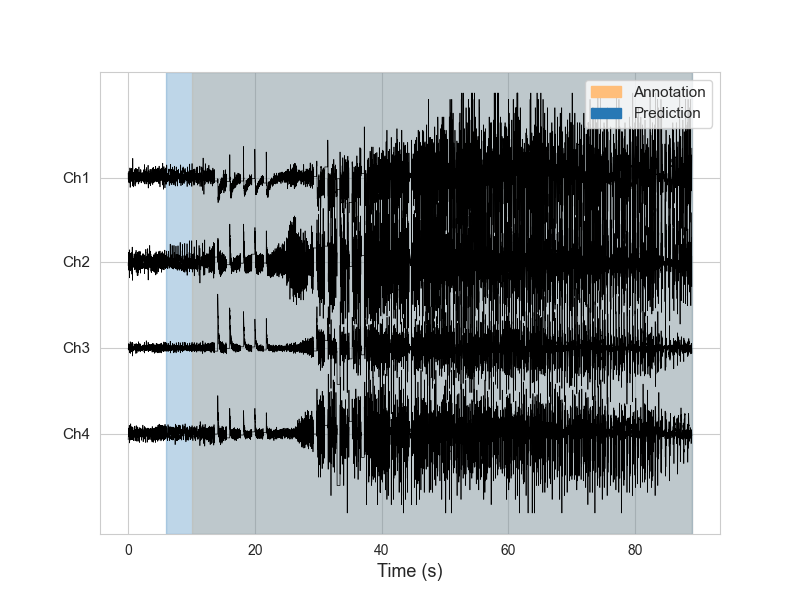

In [44]:
valid_ids = np.arange(992)[np.array([not any(list(bl)) for bl in strategy.dataset.combine_window_to_episode(strategy.dataset.labeled_idxs, seq_len_train)])]
pred_label = combine_window_to_episode(out,seq_len_out)
for sample_id in [516]:
    if sample_id in [516]:
        print(sample_id, train_index[sample_id][0])
        plot_data(get_continuous_data(train_data[sample_id]),[pred_label[sample_id],train_label[sample_id]],id = sample_id)

In [ ]:
f\]]]]]]]]]]]69lllogs




///////l




666665424444444444411***

In [29]:
per_patient_acc = {}
for p in np.unique(index_train['patient_index']):
    ind = index_train['patient_index'] == p
    ckpt_result = test_accuracy_scores(pred_raw[index_train['patient_index'] == p],
                                            target[index_train['patient_index'] == p],
                                            out[index_train['patient_index'] == p])
    acc_ckpt =ckpt_result[0]
    f1_ckpt=ckpt_result[1]
    auc_ckpt=ckpt_result[2]
    acc_round=(np.mean(acc_ckpt), np.std(acc_ckpt))
    f1_round=(np.mean(f1_ckpt), np.std(f1_ckpt))
    auc_round=(np.mean(auc_ckpt), np.std(auc_ckpt))
    scores = np.array([acc_round,f1_round,auc_round])
    per_patient_acc[p] = np.round(scores,4)


In [30]:
per_patient_acc

{b'HUP047': array([[0.9733, 0.0098],
        [0.8986, 0.0336],
        [0.9746, 0.0145]]),
 b'HUP084': array([[0.9444, 0.0177],
        [0.9107, 0.0299],
        [0.9652, 0.0152]]),
 b'HUP096': array([[0.9701, 0.0113],
        [0.9503, 0.0196],
        [0.9791, 0.0117]]),
 b'HUP109': array([[0.92  , 0.0209],
        [0.9182, 0.0212],
        [0.97  , 0.012 ]]),
 b'HUP121': array([[0.9793, 0.0073],
        [0.7064, 0.1004],
        [   nan,    nan]]),
 b'HUP129': array([[0.9349, 0.0191],
        [0.9344, 0.0195],
        [0.9686, 0.0124]]),
 b'HUP131': array([[0.9476, 0.0184],
        [0.9164, 0.027 ],
        [0.944 , 0.026 ]]),
 b'HUP137': array([[0.9614, 0.0113],
        [0.9445, 0.0168],
        [0.9844, 0.0091]]),
 b'HUP147': array([[0.9505, 0.0132],
        [0.9192, 0.0209],
        [0.9891, 0.0055]]),
 b'HUP156': array([[0.9585, 0.0124],
        [0.9584, 0.0125],
        [0.9979, 0.0011]]),
 b'HUP159': array([[0.9212, 0.0113],
        [0.9042, 0.0138],
        [0.9715, 0.0075]]),

In [95]:
np.unique(index_test['patient_index'])

array([b'HUP197', b'HUP199', b'RNS026', b'RNS029'], dtype='|S10')

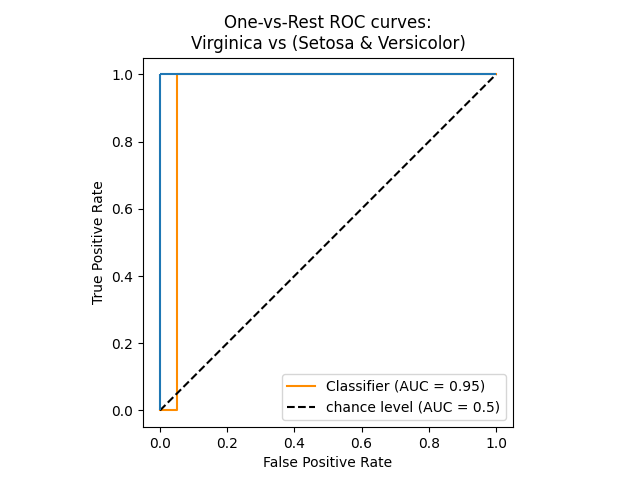

In [111]:
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay

RocCurveDisplay.from_predictions(
    np.append(target[index_test['patient_index'] == b'HUP197'],1),
    np.append(m(pred_raw.float())[:,1][index_test['patient_index'] == b'HUP197'],0.01),
    color="darkorange",
)
plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.hlines(y = 1, xmin = 0, xmax = 1)
plt.vlines(x = 0, ymin = 0, ymax = 1)
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves:\nVirginica vs (Setosa & Versicolor)")
plt.legend()
plt.show()

In [105]:

np.stack((np.append(target[index_test['patient_index'] == b'HUP197'],1),np.append(m(pred_raw.float())[:,1][index_test['patient_index'] == b'HUP197'],1)))

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 1.00000000e+00],
       [1.94181688e-03, 1.18327979e-03, 9.92726069e-04, ...,
        1.09019002e-03, 2.15314142e-03, 1.00000000e+00]])

In [104]:
np.append(target[index_test['patient_index'] == b'HUP197'],1)

array([0, 0, 0, ..., 0, 0, 1], dtype=int64)

In [ ]:
np.append(m(pred_raw.float())[:,1][index_test['patient_index'] == b'HUP197'],1)

In [90]:
per_patient_acc

{b'HUP197': array([[0.9991, 0.0032],
        [0.9665, 0.1255],
        [   nan,    nan]]),
 b'HUP199': array([[0.9106, 0.0265],
        [0.9098, 0.0267],
        [0.9696, 0.0145]]),
 b'RNS026': array([[0.9249, 0.0168],
        [0.924 , 0.0169],
        [0.9726, 0.0132]]),
 b'RNS029': array([[0.9487, 0.0122],
        [0.9401, 0.0137],
        [0.9785, 0.0074]])}

In [45]:
acc_round

(0.9672087585034014, 0.0)

In [28]:
index_train[~strategy.dataset.labeled_idxs][index_train[~strategy.dataset.labeled_idxs]['patient_index'] == b'HUP047']

array([(b'HUP047', 1102,  0,   180296), (b'HUP047', 1102,  1,   180296),
       (b'HUP047', 1102,  2,   180296), ...,
       (b'HUP047', 1201, 87, 64766937), (b'HUP047', 1201, 88, 64766937),
       (b'HUP047', 1201, 89, 64766937)],
      dtype=[('patient_index', 'S10'), ('episode_index', '<i4'), ('slice_index', '<i4'), ('start_index', '<i4')])

In [7]:
# np.save('save_acc/'+ strategy_name + '.npy', result_final)

In [38]:
add_size = []
add_episode = []
for key in list(selected_inds.keys()):
        add_size.append(len(selected_inds[key]))
        add_episode.append(np.sign(np.abs(np.diff(selected_inds[key])-1)).sum()+1)
add_size_cumsum = np.cumsum(add_size)
add_episode_cumsum = np.cumsum(add_episode)
selected_len=add_size_cumsum/3600
selected_episode=add_episode_cumsum

In [40]:
print(selected_episode)

[  9  38  65  96 125 156 196 230 266 301 336]


In [17]:
with open(log_folder_root + 'rns_active_selected/' + strategy_name + '/' + 'selected_indices.pkl', 'rb') as f:
        # Load the content of the file into a Python object
            selected_inds = pickle.load(f)
selected_inds[rd] = q_idxs
with open(log_folder_root + 'rns_active_selected/' + strategy_name + '/' + 'selected_indices.pkl', 'wb') as f:
    pickle.dump(selected_inds, f)

dict_keys([0, 1, 2, 3, 4, 5, 6, 7])

In [7]:
# raw_annotations = pd.read_csv(data_dir + 'full_updated_anns_annotTbl_cleaned.csv')
# ids = list(np.unique(raw_annotations[raw_annotations['descriptions'].notnull()]['HUP_ID']))
# # ids = list(np.unique(raw_annotations['HUP_ID']))
#
# data_import = data_utility.read_files(path=data_dir+'rns_data', path_data=data_dir+'rns_raw_cache', patientIDs=ids,
#                                       verbose=True)  # Import data with annotation

In [8]:
# data_list = os.listdir(data_dir+'rns_test_cache')
# print(data_list)


In [9]:
import torch.nn as nn
import sklearn


In [10]:
empty_dict = {}

In [11]:
result_temp = result_final

In [12]:
for k in result_temp.keys():
    empty_dict[k] = result_temp[k]

In [13]:
for k in result_temp_2.keys():
    empty_dict[k] = result_temp_2[k]

NameError: name 'result_temp_2' is not defined

In [ ]:
for k in result_final.keys():
    empty_dict[k] = result_final[k]

In [ ]:
empty_dict.keys()

In [ ]:
result_final = empty_dict

In [ ]:
result_temp_2 = result_final

In [ ]:
unlabeled_idxs

In [ ]:
[print(len(ls)) for ls in strategy.dataset.combine_window_to_episode(out, seq_len_train, ~strategy.dataset.labeled_idxs)]

In [ ]:
np.where(strategy.dataset.labeled_idxs == True)

In [ ]:

for rd in range(1, NUM_ROUND + 1):
    print('round ' + str(rd))
    log_file_name = log_folder_root + 'rns_active/active_logs_' + strategy_name + '/logger_round_' + str(
        rd) + '/version_0/metrics.csv'
    logs = pd.read_csv(log_file_name)
    max_ind = logs['val_acc'].argmax()
    max_row = logs.iloc[max_ind]
    ckpt_directory = ckpt_folder_root + 'rns_active/active_checkpoints_' + strategy_name
    ckpt_files = os.listdir(ckpt_directory)
    load_file_name = strategy_name + '_round_' + str(rd) + '-step=' + str(int(max_row['step']+1))
    print(load_file_name)

    ind = next((i for i, s in enumerate(ckpt_files) if load_file_name in s), None)
    print(ind, ckpt_files[ind])
    strategy.net.net = strategy.net.net.load_from_checkpoint(ckpt_directory + '/' + ckpt_files[ind], backbone=swav.backbone)

    with open(log_folder_root + 'rns_active_selected/' + strategy_name + '/' + 'selected_indices.pkl', 'rb') as f:
    # Load the content of the file into a Python object
        selected_inds = pickle.load(f)
    
    # selected_ind_list = []
    # for items in selected_inds.items():
    #     selected_ind_list.append(np.array(items[1]))
    q_idxs = np.array(selected_inds[rd])
    
    # with open(log_folder_root + 'rns_active_selected/' + strategy_name + '/' + 'selected_indices.pkl', 'wb') as f:
    #     pickle.dump(selected_inds, f)
# Now you can use the dictionary object as usual
    strategy.update(q_idxs)
    
    _, unlabeled_data = strategy.dataset.get_train_data_unaugmented()
    predictions = strategy.net.run_prediction(unlabeled_data)
    output_list = []
    seq_len_list = []
    target_list = []
    emb_list = []
    m = nn.Softmax(dim=1)
    for pred, y, emb, emb_t, seq_len in predictions:
        output_list.append(pred)
        seq_len_list.append(seq_len)
        target_list.append(y)
        emb_list.append(emb)

    target = torch.concat(target_list)
    emb = torch.vstack(emb_list)
    pred_raw = torch.vstack(output_list).float()
    seq_len_out = torch.tensor([item for sublist in seq_len_list for item in sublist])
    probs = m(pred_raw)
    out = torch.argmax(pred_raw, dim=1)
    unlabeled_idxs, _ = strategy.dataset.get_unlabeled_data()
    f1_score = sklearn.metrics.f1_score(target[unlabeled_idxs],out[unlabeled_idxs])

    print(f1_score)

#     strategy.net.round = rd
#     strategy.net.net.load_state_dict(modelstate)
#     torch.cuda.empty_cache()
#     strategy.train()
#     torch.cuda.empty_cache()

In [ ]:
unlabeled_idxs, _ = strategy.dataset.get_unlabeled_data()

In [ ]:
clf_report = sklearn.metrics.classification_report(torch.argmax(pred_raw, dim=1), target, digits=6)

print(f"Classification Report : \n{clf_report}")

In [ ]:
f1_score = sklearn.metrics.f1_score(target,out)

In [ ]:
f1_score